# Simulation for Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [1]:
import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind
import matplotlib.pyplot as plt

In [2]:
# Stirling numbers of second kind
S = [[0 for i in range(1001)] for j in range(1001)]

# Combinations
C = [[0 for i in range(1001)] for j in range(1001)]

def stirling(n,k,S):
    if S[n][k] > 0: return S[n][k]
    if k>n or k==0 or n==0: return 0
    if k==1 or k==n:
        S[n][k]=1
    else:
        S[n][k] = stirling(n-1,k-1,S) + k*stirling(n-1,k,S)
    return S[n][k]

def P_exact_cols(n,k,cl,S):
#     if prt: print('n,k,cl',n,k,cl)
    p = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        p*=i
    p = p*stirling(cl,k,S)
    return p

def combs(n,k,C,S):
    if C[n][k] > 0: return C[n][k]
    if k>n or k==0 or n==0: return 0
    c = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        c*=i
    C[n][k] = c*stirling(n,k,S)
    return C[n][k]

def H(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors
def H_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += k * C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors squared
def H_t_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += (k**2) * C[n][k] * (z**k)
    return h

def E_cols(n,z,C):
    return H_t(n,z,C)/H(n,z,C)

def Var_cols(n,z,C):
    EX_2 = H_t_t(n,z,C)/H(n,z,C)
    v = EX_2 - (E_cols(n,z,C)**2)
#     if v < 0: print("Negative variance in",n,z,C)
    return v

def std_cols(n,z,C):
    return Var_cols(n,z,C)**(0.5)

In [3]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

session = WolframLanguageSession()

for i in range(1001):
    if i%100==0: print(i)
    for j in range(1001):
        stirling(i,j,S)
        combs(i,j,C,S)

0
100
200
300
400
500
600
700
800
900
1000


In [4]:
def plot_avg_std_colors (N):
    max_gamma = 15
    gammas = np.linspace(0, max_gamma, num=100)
    z = [np.e**(-gamma) for gamma in gammas]
    y = [E_cols(N,zz,C) for zz in z]
    yerr = [np.real(std_cols(N,zz,C)) for zz in z]
    f = plt.figure(figsize=(18, 5))
    plt.errorbar(gammas, y, yerr=yerr, marker='o', color='black', capsize=3)
    plt.xlabel("Gamma (g)") 
    plt.ylabel("Std. num. colors")
    plt.title(str(N) + " total sites / colors")
#     plt.savefig("Expected_no_colors/avg_std_(" + str(N)+","+str(N)+")_vary_gamma_.png", format="png")
    plt.show()

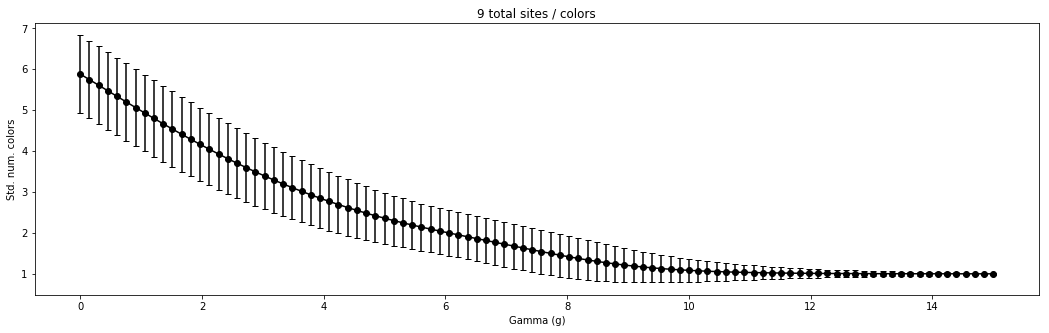

In [5]:
plot_avg_std_colors (9)

In [36]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/
# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(low=1, high=no_colors+1, size=(N,N))
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    if prt: print('current no. cols (lambda):', current_k)
    p = prob_lambda[current_k-1:]
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1)      
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]


def sample_config(config, eta, N, no_colors, sites, uf=None, cluster_constraints=None):
    
    if uf==None and not debugging:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        cluster_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.int8)
        for cluster in uf.components():
            cl_n += 1
            min_constraint = no_colors
            cluster_root = '-1,-1'
            for site_str in cluster:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    cluster_root = site_str
                cls[site[0],site[1]] = cl_n
            cluster_constraints[cluster_root] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    # Case with no field
    if alpha==0:
        '''Choose exactly how many colors to use in the configuration'''
        max_colors = eta[0] # eta_lambda
        prob_k = []
        if debugging:
            no_cl = N*N
        else:
            no_cl = len(uf.components())
        for k in range(1,max_colors+1):
            prob_k.append(P_exact_cols(no_colors,k,no_cl,S))
        if prt: print('prob_k:', prob_k)
        prob_k = [pk / sum(prob_k) for pk in prob_k]
        prob_k = np.array(prob_k)
        if prt: print('prob_k:', prob_k)
        exact_k = np.random.choice((np.arange(1, max_colors+1)), p=prob_k)
        if prt: print('exact number of colors to use in configuration:')
        if prt: print(exact_k)
            
        if debugging:
            chosen_colors = range(1,exact_k+1)
            if exact_k == no_colors:
                chosen_partition = [exact_k]
            else:
                chosen_partition = [exact_k-1] + [0]*max(0,no_colors-exact_k-1) + [1]
            if prt: print('chosen partition:')
            if prt: print(chosen_partition)
            part = []
            for i in range(len(chosen_partition)):
                part += ([i+1]*chosen_partition[i])
            chosen_partition = part
            if prt: print('chosen partition:')
            if prt: print(chosen_partition)
            color_arr = []
            for i in range(len(chosen_partition)):
                color_arr += [chosen_colors[i]]*chosen_partition[i]
            config = np.array(color_arr).reshape((N,N))
            return config, None, None
            

        '''Sample a partition of the no. of clusters into k using Bell polynomials'''
        session.evaluate("subs = Array[x,"+str(no_cl-exact_k+1)+"]")
        partition_dict = session.evaluate("Association@CoefficientRules[BellY["+str(no_cl)+", "+str(exact_k)+", subs],subs]")
        if prt: print("partition_dict", partition_dict)
        partitions = []
        partition_p = []
        for partition in partition_dict:
            partitions.append(partition)
            partition_p.append(partition_dict[partition])
        if prt: print('partition_p:', partition_p)
        partition_p = [pk / sum(partition_p) for pk in partition_p]
        parition_p = np.array(partition_p)
        if prt: print('partition_p:', partition_p)
        chosen_partition = partitions[np.random.choice((np.arange(0, len(partitions))), p=partition_p)]
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)
        # Transform to actual partition
        part = []
        for i in range(len(chosen_partition)):
            part += ([i+1]*chosen_partition[i])
        chosen_partition = part
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)

        '''Color each block in the partition randomly without replacement'''
        # Choose the colors to be used
        chosen_colors = np.random.choice((np.arange(1, no_colors+1)), len(chosen_partition), replace=False)
        # Choose a random permutation of the given word
        color_arr = []
        for i in range(len(chosen_partition)):
            color_arr += [chosen_colors[i]]*chosen_partition[i]
        color_arr = np.array(color_arr)
        color_arr = np.random.permutation(color_arr)
        if prt: print('colors for clusters:')
        if prt: print(color_arr)
        
        '''Color each cluster with the assigned color'''
        i=0
        for root in cluster_constraints:
            cluster_color = color_arr[i]
            for site_str in uf.component(root):
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            i+=1
    
    # Case with field
    else:
        '''Randomly sample a color for each cluster'''
        for root in cluster_constraints:
            max_col = cluster_constraints[root]
            cluster_color = np.random.choice((np.arange(1, max_col+1)))
            for site_str in uf.clusteronent(root):
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            
    return config, uf, cluster_constraints


def assign_labels(config, eta, N, no_colors, sites):
    '''Assign a color configuration chosen uniformly from the configurations clusteratible with eta'''
    # Brute force version
    max_colors = eta[0] # eta_lambda
    config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites)
    while number_of_colors(config) > max_colors:
        config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, uf, cluster_constraints)
        if prt: print('retrying sample (too many colors)')
    return config

## Experiment routine

In [37]:
# Small experiment

debugging = True
prt = True
N, no_cols = 3, 9
gamma = 0.12    # strength of preference for low no. of cols
J = 0      # strength of preference for bonds
alpha = 0  # strength of preference for colors (field)

'''Probabilities ordered from highest (high energy) to lowest'''
lambda_prob = np.zeros(no_cols)
for j in range(no_cols):
    lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
print('lambda probabilities:', lambda_prob)

edge_prob = np.zeros(2)
edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
print('edge probabilities:', edge_prob)

site_prob = np.zeros(no_cols)
for j in range(no_cols):
    site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
print('site probabilities:', site_prob)

eta_prob = (lambda_prob, edge_prob, site_prob)

'''Current states of eta'''
eta_lambda = 0
eta_edges = np.zeros((N,N,2), dtype=np.int8)
# Special edge cases (no neighbors at the border)
eta_edges[:,N-1,1] = -1
eta_edges[N-1,:,0] = -1
eta_sites = np.zeros((N,N), dtype=np.int8)
eta = [eta_lambda, eta_edges, eta_sites]

'''List of sites (tuples) for Union-Find'''
sites = []
for i in range(N):
    for j in range(N):
        sites.append(str(i)+','+str(j))

config = initial_config(N, no_cols)
print('\ninitial config:')
print(config)
for i in range(100):
    if prt: print('\n' + '-'*20 + ' iter ' + str(i) + ' ' + '-'*20)
    config = mc_move(config, eta_prob, eta, N, no_cols, sites)
    # if i%100 == 0: print(i)

print('\nfinal config:')
print(config)

session.terminate()

lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[7 6 3]
 [6 8 3]
 [1 3 8]]

-------------------- iter 0 --------------------
probabilities for no. of colors (lambda): [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
current no. cols (lambda): 5
assigned no. cols (eta_lambda): 9
probabilities for edges: [0. 1.]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
prob_k: [9, 18360, 1524600, 23496480, 105099120, 160030080, 83825280, 13063680, 362880]
prob_k: [2.32305731e-08 4.73903692e-05 3.93525909e-03 6.06485219e-02
 2.71279199e-01 4.13065608e-01 2.16367700e-01 3.37196415e-02
 9.36656708e-04]
ex

current no. cols (lambda): 4
assigned no. cols (eta_lambda): 8
probabilities for edges: [0. 1.]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
prob_k: [9, 18360, 1524600, 23496480, 105099120, 160030080, 83825280, 13063680]
prob_k: [2.32523526e-08 4.74347993e-05 3.93894853e-03 6.07053820e-02
 2.71533533e-01 4.13452872e-01 2.16570552e-01 3.37512548e-02]
exact number of colors to use in configuration:
7
chosen partition:
[6, 0, 1]
chosen partition:
[1, 1, 1, 1, 1, 1, 3]
config:
[[1 2 3]
 [4 5 6]
 [7 7 7]]

-------------------- iter 25 --------------------
probabilities for no. of colors (lambda): [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
current no. cols (lambda): 7
assigned no. cols (eta_lambda): 9
probabilities for edges: [0. 1.]
assigned bonds (eta_e

 [9 9 9]]
prob_k: [9, 18360, 1524600, 23496480, 105099120, 160030080, 83825280, 13063680, 362880]
prob_k: [2.32305731e-08 4.73903692e-05 3.93525909e-03 6.06485219e-02
 2.71279199e-01 4.13065608e-01 2.16367700e-01 3.37196415e-02
 9.36656708e-04]
exact number of colors to use in configuration:
5
chosen partition:
[4, 0, 0, 0, 1]
chosen partition:
[1, 1, 1, 1, 5]
config:
[[1 2 3]
 [4 5 5]
 [5 5 5]]

-------------------- iter 56 --------------------
probabilities for no. of colors (lambda): [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
current no. cols (lambda): 5
assigned no. cols (eta_lambda): 9
probabilities for edges: [0. 1.]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
prob_k: [9, 18360, 1524600, 23496480, 105099120, 160030080, 83825280, 13063680, 362

assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
prob_k: [9, 18360, 1524600, 23496480, 105099120, 160030080, 83825280]
prob_k: [2.40645618e-08 4.90917060e-05 4.07653676e-03 6.28258327e-02
 2.81018252e-01 4.27894860e-01 2.24135403e-01]
exact number of colors to use in configuration:
6
chosen partition:
[5, 0, 0, 1]
chosen partition:
[1, 1, 1, 1, 1, 4]
config:
[[1 2 3]
 [4 5 6]
 [6 6 6]]

-------------------- iter 89 --------------------
probabilities for no. of colors (lambda): [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
current no. cols (lambda): 6
assigned no. cols (eta_lambda): 7
probabilities for edges: [0. 1.]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0

In [32]:
a = [16, 7864080, 23996064960, 7504175995680, 574579238688000, 15768930151054080, 189225474428390400, 1111400775560275200, 3407360398041600000, 5630409646557696000, 5045340384103219200, 2403608358767616000, 577538743541760000, 62977597562880000, 2510734786560000, 20922789888000]
sum(a),16**16

(18446744073709551616, 18446744073709551616)

## Full simulation

In [41]:
'''Parameters'''
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
ngamma, nalpha, nJ = 5, 20, 10
gammas = np.logspace(-2,5, base=np.e, num=ngamma).round(decimals=2)
alphas = np.logspace(-1,5, base=np.e, num=nalpha).round(decimals=2)
Js = np.logspace(-1,5, base=np.e, num=nJ).round(decimals=2)

In [42]:
def experiment_full_interaction_gamma (N, no_cols, gammas, J=1, alpha=1):
    '''Run simulation for different gammas given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    print('edge probabilities:', edge_prob)
    
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    print('site probabilities:', site_prob)
    
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(ngamma), np.zeros(ngamma)
    std_c, std_s_c = np.zeros(ngamma), np.zeros(ngamma)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter across the logspace'''
    print('Trying gammas:', gammas)
    for igamma in range(ngamma):
        
        '''Probabilities for the varying parameter'''
        gamma = gammas[igamma]
        lambda_prob = np.zeros(no_cols)
        for j in range(no_cols):
            lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
        print(igamma, ' - gamma:', gamma)
        print('lambda probabilities:', lambda_prob)
        
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
        print('Final configuration:')
        print(config)
        avg_c[igamma] = tot_c / (mc_steps)
        avg_s_c[igamma] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[igamma], avg_s_c[igamma])
        std_c[igamma] = np.std(no_cols_arr)
        std_s_c[igamma] = np.std(no_sites_arr)
        print('Final stds:', std_c[igamma], std_s_c[igamma])
        print('-'*120 + '\n')
    
    f = plt.figure(figsize=(18, 5)); # plot the calculated values 
    
    my_max_gamma = 15
    my_gammas = np.linspace(0, my_max_gamma, num=200)
    z = [np.e**(-my_gamma) for my_gamma in my_gammas]
    y = [E_cols(N*N,zz,C) for zz in z]
    yerr = [np.real(std_cols(N*N,zz,C)) for zz in z]
    plt.errorbar(my_gammas, y, yerr=yerr, marker='o', color='black', capsize=3)
    
    plt.errorbar(gammas, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    
    plt.title(str(N*N) + " total sites / colors", fontsize=20)
    plt.xlabel("Gamma (g)", fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.savefig("Simulation_all_interaction_vs_exp/avg_std_(" + str(N)+","+str(N)+")_J_"+str(J)+"_alpha_"+str(alpha)+"_vary_gamma_.png", format="png")
    
    plt.show()

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying gammas: [ 0.12  0.16  0.21  0.27  0.35  0.45  0.58  0.75  0.96  1.24  1.61  2.07
  2.68  3.46  4.46  5.76  7.44  9.6  12.39 16.  ]
0  - gamma: 0.12
lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
Initial configuration
[[5 7 1]
 [9 7 1]
 [6 4 3]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 6.0 avg. sites per col: 1.5
101 num. cols: 5.683168316831683 avg. sites per col: 1.631117397454032
201 num. cols: 5.7711442786069655 avg. sites per col: 1.5992537313432849
301 num. cols: 5.8006644518272426 avg. sites per col: 1.5885263407688672
401 num. cols: 5.8104738154613464 avg. sites per col: 1.5867830423940152
501 num. cols: 5.798403193612774 avg. sites per col: 1.5908468776732239
601 num. cols: 5.813643926788686 avg. sites 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 1.8
101 num. cols: 5.425742574257426 avg. sites per col: 1.72977369165488
201 num. cols: 5.223880597014926 avg. sites per col: 1.8019722814498955
301 num. cols: 5.308970099667774 avg. sites per col: 1.7604888467014732
401 num. cols: 5.321695760598503 avg. sites per col: 1.7621125757035974
501 num. cols: 5.331337325349302 avg. sites per col: 1.75624465355004
601 num. cols: 5.316139767054908 avg. sites per col: 1.7573924411694737
701 num. cols: 5.315263908701854 avg. sites per col: 1.757907071530458
801 num. cols: 5.3158551810237205 avg. sites per col: 1.7567148207597543
901 num. cols: 5.3152053274139845 avg. sites per col: 1.7555612811162076
1001 num. cols: 5.302697302697303 avg. sites per col: 1.7596796061081639
Final configuration:
[[6 7 8]
 [6 9 8]
 [8 1 8]]
Final averages: 5.303482587064677 1.7592430703624597
Final stds: 0.

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 2.25
101 num. cols: 3.198019801980198 avg. sites per col: 2.9331683168316833
201 num. cols: 3.5472636815920398 avg. sites per col: 2.6716417910447774
301 num. cols: 3.6943521594684388 avg. sites per col: 2.550996677740862
401 num. cols: 3.57356608478803 avg. sites per col: 2.686533665835409
501 num. cols: 3.6087824351297404 avg. sites per col: 2.6422155688622726
601 num. cols: 3.6289517470881862 avg. sites per col: 2.6201331114808624
701 num. cols: 3.6333808844507844 avg. sites per col: 2.6171897289586274
801 num. cols: 3.6504369538077404 avg. sites per col: 2.604119850187263
901 num. cols: 3.6148723640399556 avg. sites per col: 2.638235294117646
1001 num. cols: 3.652347652347652 avg. sites per col: 2.60754245754246
Final configuration:
[[6 1 6]
 [7 1 6]
 [1 5 7]]
Final averages: 3.653731343283582 2.606119402985077
Final stds:

101 num. cols: 1.0 avg. sites per col: 9.0
201 num. cols: 1.0 avg. sites per col: 9.0
301 num. cols: 1.0 avg. sites per col: 9.0
401 num. cols: 1.0 avg. sites per col: 9.0
501 num. cols: 1.0 avg. sites per col: 9.0
601 num. cols: 1.0 avg. sites per col: 9.0
701 num. cols: 1.0 avg. sites per col: 9.0
801 num. cols: 1.0 avg. sites per col: 9.0
901 num. cols: 1.0 avg. sites per col: 9.0
1001 num. cols: 1.0 avg. sites per col: 9.0
Final configuration:
[[5 5 5]
 [5 5 5]
 [5 5 5]]
Final averages: 1.0 9.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - gamma: 16.0
lambda probabilities: [9.99999887e-01 1.12535162e-07 1.26641641e-14 1.42516392e-21
 1.60381071e-28 1.80485118e-35 2.03109243e-42 2.28569342e-49
 2.57220937e-56]
Initial configuration
[[4 6 1]
 [7 6 7]
 [4 3 5]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equ

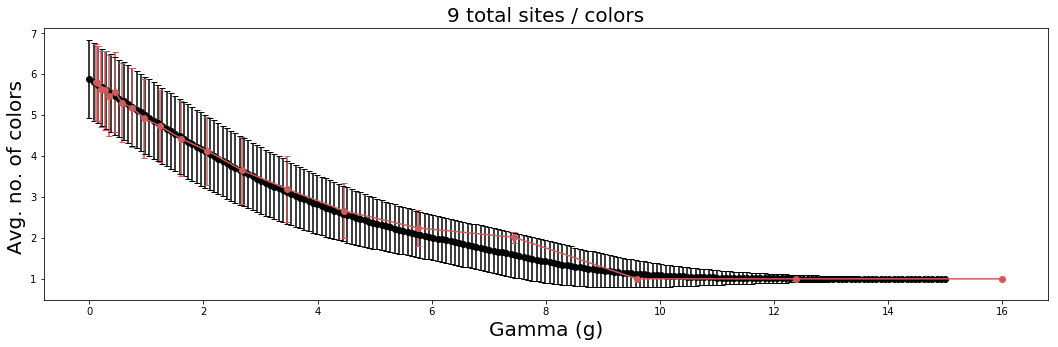

In [26]:
debugging  = False
prt = False
ngamma = 20
gammas = np.logspace(-3,4, base=2, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (3, 9, gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying gammas: [ 0.12  0.16  0.21  0.27  0.35  0.45  0.58  0.75  0.96  1.24  1.61  2.07
  2.68  3.46  4.46  5.76  7.44  9.6  12.39 16.  ]
0  - gamma: 0.12
lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
Initial configuration
[[3 5 3]
 [8 7 7]
 [1 2 7]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 6.0 avg. sites per col: 1.5
101 num. cols: 5.633663366336633 avg. sites per col: 1.631541725601132
201 num. cols: 5.741293532338308 avg. sites per col: 1.607356076759063
301 num. cols: 5.774086378737541 avg. sites per col: 1.604579971523494
401 num. cols: 5.7556109725685785 avg. sites per col: 1.6065016031350188
501 num. cols: 5.758483033932135 avg. sites per col: 1.6061163387510677
601 num. cols: 5.747088186356073 avg. sites per 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 2.25
101 num. cols: 5.3861386138613865 avg. sites per col: 1.7271216407355012
201 num. cols: 5.383084577114428 avg. sites per col: 1.727718550106611
301 num. cols: 5.382059800664452 avg. sites per col: 1.7294494542002863
401 num. cols: 5.3915211970074814 avg. sites per col: 1.728847524047024
501 num. cols: 5.385229540918163 avg. sites per col: 1.730089820359278
601 num. cols: 5.356073211314476 avg. sites per col: 1.746125505110525
701 num. cols: 5.370898716119829 avg. sites per col: 1.7395506419400777
801 num. cols: 5.33083645443196 avg. sites per col: 1.7544007490636606
901 num. cols: 5.341842397336293 avg. sites per col: 1.7499603615030803
1001 num. cols: 5.344655344655345 avg. sites per col: 1.749446981589826
Final configuration:
[[1 2 3]
 [4 5 6]
 [6 6 6]]
Final averages: 5.3462686567164175 1.7487526652451897
Final stds: 0

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 3.0
101 num. cols: 3.712871287128713 avg. sites per col: 2.613224893917965
201 num. cols: 3.7412935323383083 avg. sites per col: 2.540724946695098
301 num. cols: 3.6345514950166113 avg. sites per col: 2.5956336022781215
401 num. cols: 3.6433915211970076 avg. sites per col: 2.5857499109369417
501 num. cols: 3.684630738522954 avg. sites per col: 2.542985457656115
601 num. cols: 3.737104825291181 avg. sites per col: 2.50871167102448
701 num. cols: 3.7503566333808847 avg. sites per col: 2.4942734868555094
801 num. cols: 3.766541822721598 avg. sites per col: 2.482691278758691
901 num. cols: 3.8157602663706993 avg. sites per col: 2.4520374187410825
1001 num. cols: 3.825174825174825 avg. sites per col: 2.446389324960759
Final configuration:
[[1 2 3]
 [3 3 3]
 [3 3 3]]
Final averages: 3.8228855721393034 2.447846481876338
Final stds: 0

801 num. cols: 1.0 avg. sites per col: 9.0
901 num. cols: 1.0 avg. sites per col: 9.0
1001 num. cols: 1.0 avg. sites per col: 9.0
Final configuration:
[[1 1 1]
 [1 1 1]
 [1 1 1]]
Final averages: 1.0 9.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - gamma: 16.0
lambda probabilities: [9.99999887e-01 1.12535162e-07 1.26641641e-14 1.42516392e-21
 1.60381071e-28 1.80485118e-35 2.03109243e-42 2.28569342e-49
 2.57220937e-56]
Initial configuration
[[7 7 7]
 [8 3 7]
 [7 5 1]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.0 avg. sites per col: 9.0
201 num. cols: 1.0 avg. sites per col: 9.0
301 num. cols: 1.0 avg. sites per col: 9.0
401 num. cols: 1.0 avg. sites per col: 9.0
501 num. cols: 1.0 avg. sites per col: 9.0
601 num. cols: 1.0 avg.

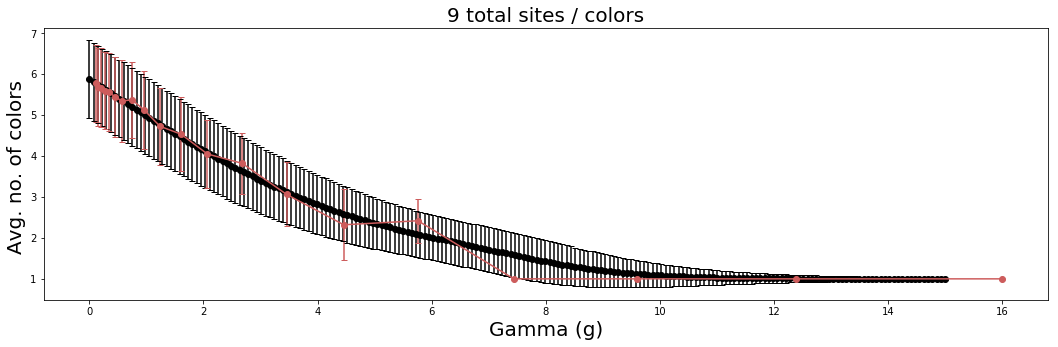

In [43]:
debugging  = True
prt = False
ngamma = 20
gammas = np.logspace(-3,4, base=2, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (3, 9, gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying gammas: [ 0.12  0.16  0.21  0.27  0.35  0.45  0.58  0.75  0.96  1.24  1.61  2.07
  2.68  3.46  4.46  5.76  7.44  9.6  12.39 16.  ]
0  - gamma: 0.12
lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.04329736 0.03840131 0.03405891 0.03020754
 0.02679169 0.0237621  0.02107509 0.16529889]
Initial configuration
[[ 3  5 15  6]
 [ 5 10 12  3]
 [15  5  9 13]
 [12 16  2  1]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 2.2857142857142856
101 num. cols: 7.455445544554456 avg. sites per col: 2.1760176017601744
201 num. cols: 7.45771144278607 avg. sites per col: 2.1755981994787947
301 num. cols: 7.511627906976744 avg. sites per col: 2.1625481200232075
401 num. cols: 7.516209476309227 avg. sites 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 8.0 avg. sites per col: 2.0
101 num. cols: 7.188118811881188 avg. sites per col: 2.2670438472418653
201 num. cols: 7.1940298507462686 avg. sites per col: 2.2628760957119147
301 num. cols: 7.239202657807309 avg. sites per col: 2.252069820176137
401 num. cols: 7.192019950124688 avg. sites per col: 2.270070854609515
501 num. cols: 7.2375249500998 avg. sites per col: 2.254931407027224
601 num. cols: 7.2579034941763725 avg. sites per col: 2.2484747642817586
701 num. cols: 7.2781740370898715 avg. sites per col: 2.24184045467926
801 num. cols: 7.295880149812734 avg. sites per col: 2.2347066167290897
901 num. cols: 7.30188679245283 avg. sites per col: 2.2309250744322875
1001 num. cols: 7.274725274725275 avg. sites per col: 2.239684125398404
Final configuration:
[[11  2 11  1]
 [ 2  2  6  6]
 [ 1  2 13 12]
 [ 6 11  2  2]]
Final averages: 7.27363184079602 2.24

301 num. cols: 6.465116279069767 avg. sites per col: 2.515888836154618
401 num. cols: 6.341645885286783 avg. sites per col: 2.5838419823457266
501 num. cols: 6.339321357285429 avg. sites per col: 2.582264043341897
601 num. cols: 6.292845257903494 avg. sites per col: 2.6060164276470568
701 num. cols: 6.1997146932952925 avg. sites per col: 2.6497203541426253
801 num. cols: 6.239700374531835 avg. sites per col: 2.630584784891914
901 num. cols: 6.188679245283019 avg. sites per col: 2.655856808132056
1001 num. cols: 6.245754245754246 avg. sites per col: 2.6299922299922196
Final configuration:
[[15 15  2  4]
 [16  4 16  4]
 [ 2 15 12  2]
 [ 2 15 12 15]]
Final averages: 6.240796019900498 2.632260917634041
Final stds: 0.979251091235364 0.44739825248103826
------------------------------------------------------------------------------------------------------------------------

11  - gamma: 2.07
lambda probabilities: [8.73814218e-01 1.10262930e-01 1.39136140e-02 1.75570026e-03
 2.21544410e-04 2.7

801 num. cols: 3.435705368289638 avg. sites per col: 4.766375364128173
901 num. cols: 3.4983351831298557 avg. sites per col: 4.6813170551239365
1001 num. cols: 3.5634365634365635 avg. sites per col: 4.601265401265398
Final configuration:
[[14  5 14 13]
 [14  8  3  3]
 [ 3  8  5 13]
 [ 8  8  8  3]]
Final averages: 3.569154228855721 4.595688225538969
Final stds: 0.5699295418568174 0.712273498628615
------------------------------------------------------------------------------------------------------------------------

16  - gamma: 7.44
lambda probabilities: [9.99412715e-01 5.86940294e-04 3.44701346e-07 2.02437998e-10
 1.18888840e-13 6.98216558e-17 4.10052249e-20 2.40817616e-23
 1.41428621e-26 8.30589358e-30 4.87792835e-33 2.86473511e-36
 1.68241653e-39 9.88058323e-43 5.80272027e-46 3.40985428e-49]
Initial configuration
[[12  7  4 12]
 [11 13 12 16]
 [13 15  6  4]
 [ 9  8 13 10]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration

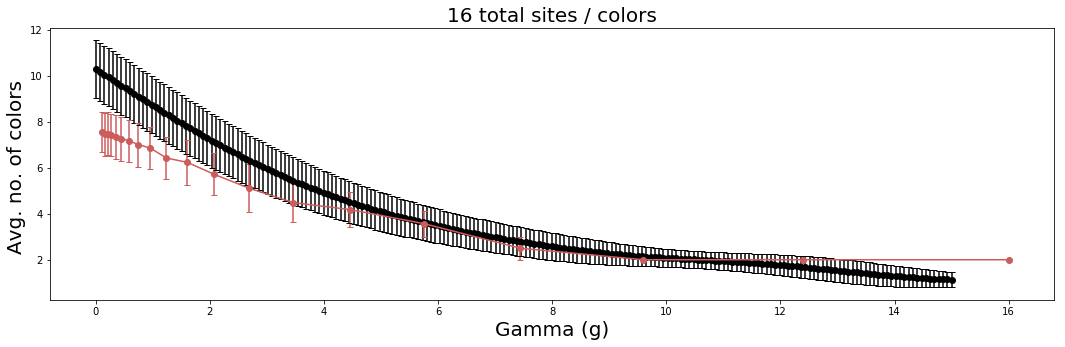

In [27]:
debugging  = False
prt = False
ngamma = 20
gammas = np.logspace(-3,4, base=2, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (4, 16, gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying gammas: [ 0.12  0.16  0.21  0.27  0.35  0.45  0.58  0.75  0.96  1.24  1.61  2.07
  2.68  3.46  4.46  5.76  7.44  9.6  12.39 16.  ]
0  - gamma: 0.12
lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.04329736 0.03840131 0.03405891 0.03020754
 0.02679169 0.0237621  0.02107509 0.16529889]
Initial configuration
[[11  3  8  1]
 [ 4 12 13 16]
 [ 6 13 14  4]
 [ 2  6 13  8]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 10.0 avg. sites per col: 1.6
101 num. cols: 10.198019801980198 avg. sites per col: 1.5909362364807902
201 num. cols: 10.139303482587065 avg. sites per col: 1.5996905250636588
301 num. cols: 10.056478405315614 avg. sites per col: 1.6132708930051116
401 num. cols: 10.174563591022444 avg. sites per col: 

equilibration step: 4000
equilibration step: 5000
1 num. cols: 8.0 avg. sites per col: 2.0
101 num. cols: 9.366336633663366 avg. sites per col: 1.7457460031717442
201 num. cols: 9.611940298507463 avg. sites per col: 1.6980081278588746
301 num. cols: 9.704318936877076 avg. sites per col: 1.6789760258198803
401 num. cols: 9.71072319201995 avg. sites per col: 1.676083849649943
501 num. cols: 9.666666666666666 avg. sites per col: 1.6844324892229217
601 num. cols: 9.608985024958402 avg. sites per col: 1.6948541567510116
701 num. cols: 9.594864479315264 avg. sites per col: 1.6977693411359736
801 num. cols: 9.627965043695381 avg. sites per col: 1.6924987067309274
901 num. cols: 9.618201997780243 avg. sites per col: 1.6931896812030067
1001 num. cols: 9.61038961038961 avg. sites per col: 1.695394227262364
Final configuration:
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 10 10]
 [10 10 10 10]]
Final averages: 9.61094527363184 1.6951914420571186
Final stds: 1.2683987641375725 0.23513718470395273
-------

601 num. cols: 7.550748752079867 avg. sites per col: 2.18091732634163
701 num. cols: 7.621968616262482 avg. sites per col: 2.162853725763864
801 num. cols: 7.627965043695381 avg. sites per col: 2.1594615677012774
901 num. cols: 7.69700332963374 avg. sites per col: 2.137733767034552
1001 num. cols: 7.701298701298701 avg. sites per col: 2.134211531614134
Final configuration:
[[1 2 3 4]
 [5 6 7 8]
 [8 8 8 8]
 [8 8 8 8]]
Final averages: 7.708457711442786 2.132483326513182
Final stds: 1.2042950124730234 0.37298992652511653
------------------------------------------------------------------------------------------------------------------------

11  - gamma: 2.07
lambda probabilities: [8.73814218e-01 1.10262930e-01 1.39136140e-02 1.75570026e-03
 2.21544410e-04 2.79557546e-05 3.52761875e-06 4.45135329e-07
 5.61697495e-08 7.08782374e-09 8.94382580e-10 1.12858365e-10
 1.42411210e-11 1.79702699e-12 2.26759255e-13 3.27458552e-14]
Initial configuration
[[ 1  3  1  3]
 [10 14 14  7]
 [13 16 15 14]
 [

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 2.0 avg. sites per col: 8.0
201 num. cols: 2.0 avg. sites per col: 8.0
301 num. cols: 2.1362126245847177 avg. sites per col: 7.6367663344407735
401 num. cols: 2.3516209476309227 avg. sites per col: 7.062344139650926
501 num. cols: 2.4810379241516967 avg. sites per col: 6.717232202262215
601 num. cols: 2.56738768718802 avg. sites per col: 6.486966167498699
701 num. cols: 2.7004279600570613 avg. sites per col: 6.2272943414171
801 num. cols: 2.8626716604244695 avg. sites per col: 5.9492301290054765
901 num. cols: 2.9889012208657046 avg. sites per col: 5.732889382168021
1001 num. cols: 3.0899100899100898 avg. sites per col: 5.559773559773613
Final configuration:
[[1 2 3 4]
 [4 4 4 4]
 [4 4 4 4]
 [4 4 4 4]]
Final averages: 3.093532338308458 5.5535655058043645
Final stds: 0.7760135149096263 1.5547959829632907
----

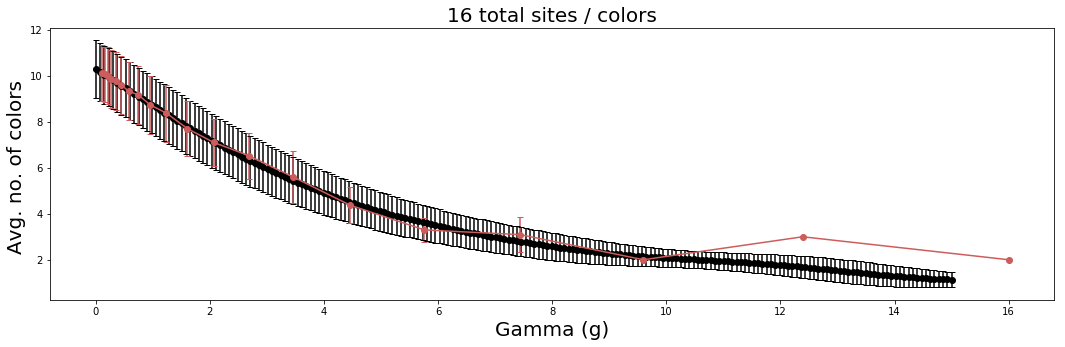

In [44]:
debugging  = True
prt = False
ngamma = 20
gammas = np.logspace(-3,4, base=2, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (4, 16, gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying gammas: [ 0.12  0.16  0.21  0.27  0.35  0.45  0.58  0.75  0.96  1.24  1.61  2.07
  2.68  3.46  4.46  5.76  7.44  9.6  12.39 16.  ]
0  - gamma: 0.12
lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.04329736 0.03840131 0.03405891 0.03020754
 0.02679169 0.0237621  0.02107509 0.01869193 0.01657825 0.01470359
 0.01304091 0.01156625 0.01025835 0.00909834 0.0080695  0.00715701
 0.05613476]
Initial configuration
[[23 20 20  1  9]
 [12 13  4  4 23]
 [23  1 24 21 10]
 [ 6  5 18  7  6]
 [11  5 20 19 21]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 2.7777777777777777
101 num. cols: 8.613861386138614 avg. sites per col: 2.917256011315415
201 num. cols: 8.557213930348

801 num. cols: 8.382022471910112 avg. sites per col: 3.003314309494104
901 num. cols: 8.402885682574917 avg. sites per col: 2.995404136497386
1001 num. cols: 8.398601398601398 avg. sites per col: 2.996755228898105
Final configuration:
[[22 19 22 24 23]
 [ 6  3 19 23  6]
 [23 17  3 24 20]
 [22  3 19  6 20]
 [ 6  6 24 20 20]]
Final averages: 8.398009950248756 2.9969201610992844
Final stds: 0.662271096210696 0.25540538298523474
------------------------------------------------------------------------------------------------------------------------

5  - gamma: 0.45
lambda probabilities: [3.62371848e-01 2.31058492e-01 1.47329399e-01 9.39413724e-02
 5.98996637e-02 3.81937118e-02 2.43533859e-02 1.55284044e-02
 9.90134781e-03 6.31337810e-03 4.02558761e-03 2.56682799e-03
 1.63668178e-03 1.04359438e-03 6.65425156e-04 4.24293812e-04
 2.70541679e-04 1.72504991e-04 1.09994039e-04 7.01352955e-05
 4.47202388e-05 2.85148832e-05 1.81818923e-05 1.15932864e-05
 2.03995034e-05]
Initial configuration
[[ 5 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 6.0 avg. sites per col: 4.166666666666667
101 num. cols: 7.524752475247524 avg. sites per col: 3.3769448373408735
201 num. cols: 7.8059701492537314 avg. sites per col: 3.2439489062623386
301 num. cols: 7.691029900332226 avg. sites per col: 3.292760902810734
401 num. cols: 7.713216957605985 avg. sites per col: 3.2874163796857125
501 num. cols: 7.822355289421158 avg. sites per col: 3.239156607420091
601 num. cols: 7.816971713810316 avg. sites per col: 3.239640282069583
701 num. cols: 7.7660485021398005 avg. sites per col: 3.2629123927269554
801 num. cols: 7.750312109862672 avg. sites per col: 3.2679265006044074
901 num. cols: 7.763596004439512 avg. sites per col: 3.264120113454187
1001 num. cols: 7.781218781218781 avg. sites per col: 3.2546818261103967
Final configuration:
[[19 14  6  4  4]
 [ 4 19  6 11 19]
 [ 6 21  4 19 14]
 [24 14  6  4 14]
 [17 24 

14  - gamma: 4.46
lambda probabilities: [9.88437637e-01 1.14286750e-02 1.32142493e-04 1.52787951e-06
 1.76658979e-08 2.04259530e-10 2.36172289e-12 2.73070980e-14
 3.15734587e-16 3.65063800e-18 4.22100028e-20 4.88047387e-22
 5.64298118e-24 6.52461985e-26 7.54400250e-28 8.72264975e-30
 1.00854445e-31 1.16611574e-33 1.34830538e-35 1.55895966e-37
 1.80252579e-39 2.08414581e-41 2.40976509e-43 2.78625795e-45
 3.25925738e-47]
Initial configuration
[[ 3 10 11  8 25]
 [19 20 24 10 22]
 [17 21  9 22 23]
 [10  1 16 17 16]
 [23  8 10 23  2]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 5.0
101 num. cols: 6.03960396039604 avg. sites per col: 4.180810938236679
201 num. cols: 5.587064676616915 avg. sites per col: 4.665955934612646
301 num. cols: 5.059800664451827 avg. sites per col: 5.192216421452299
401 num. cols: 5.017456359102244 avg. sites per col: 5.178571428

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 8.333333333333334
101 num. cols: 3.0 avg. sites per col: 8.333333333333343
201 num. cols: 3.0 avg. sites per col: 8.333333333333313
301 num. cols: 3.0 avg. sites per col: 8.333333333333337
401 num. cols: 3.0 avg. sites per col: 8.333333333333373
501 num. cols: 3.0 avg. sites per col: 8.333333333333387
601 num. cols: 3.0 avg. sites per col: 8.333333333333329
701 num. cols: 3.0 avg. sites per col: 8.333333333333286
801 num. cols: 3.0 avg. sites per col: 8.333333333333254
901 num. cols: 3.0 avg. sites per col: 8.33333333333323
1001 num. cols: 3.0 avg. sites per col: 8.333333333333226
Final configuration:
[[10 10  7 12  7]
 [ 7  7 10 12 10]
 [10 10  7  7  7]
 [12 12 10 10 12]
 [10  7 10 10 12]]
Final averages: 3.0 8.33333333333323
Final stds: 0.0 1.7763568394002505e-15
--------------------------------------------------------------

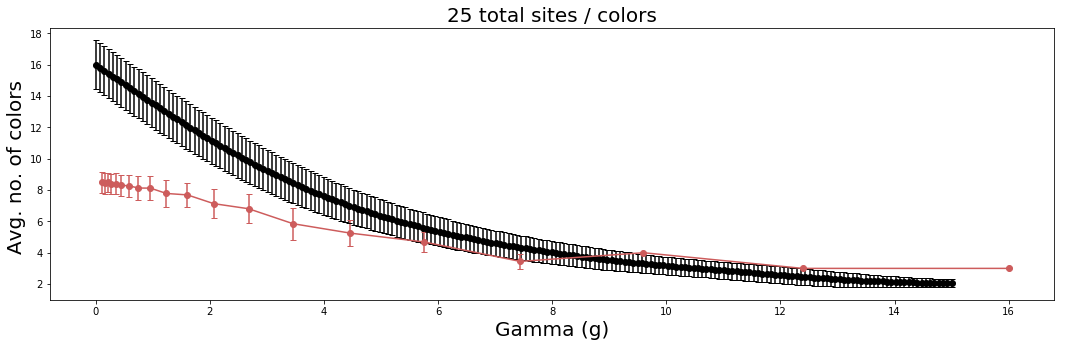

In [28]:
debugging  = False
prt = False
ngamma = 20
gammas = np.logspace(-3,4, base=2, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (5, 25, gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying gammas: [ 0.12  0.16  0.21  0.27  0.35  0.45  0.58  0.75  0.96  1.24  1.61  2.07
  2.68  3.46  4.46  5.76  7.44  9.6  12.39 16.  ]
0  - gamma: 0.12
lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.04329736 0.03840131 0.03405891 0.03020754
 0.02679169 0.0237621  0.02107509 0.01869193 0.01657825 0.01470359
 0.01304091 0.01156625 0.01025835 0.00909834 0.0080695  0.00715701
 0.05613476]
Initial configuration
[[19  1 12  8 22]
 [ 8 17  4 22  8]
 [19 21 18 17  5]
 [ 4  3  6  5  7]
 [18  4 20  8 25]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 18.0 avg. sites per col: 1.3888888888888888
101 num. cols: 15.178217821782178 avg. sites per col: 1.662525294223022
201 num. cols: 15.492537313

701 num. cols: 14.952924393723253 avg. sites per col: 1.6916988856373354
801 num. cols: 14.872659176029963 avg. sites per col: 1.702023253152503
901 num. cols: 14.849056603773585 avg. sites per col: 1.7045039473367736
1001 num. cols: 14.883116883116884 avg. sites per col: 1.700688318443629
Final configuration:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 18 18]
 [18 18 18 18 18]]
Final averages: 14.887562189054727 1.7001998655110813
Final stds: 1.6385573461068674 0.19251982498630216
------------------------------------------------------------------------------------------------------------------------

5  - gamma: 0.45
lambda probabilities: [3.62371848e-01 2.31058492e-01 1.47329399e-01 9.39413724e-02
 5.98996637e-02 3.81937118e-02 2.43533859e-02 1.55284044e-02
 9.90134781e-03 6.31337810e-03 4.02558761e-03 2.56682799e-03
 1.63668178e-03 1.04359438e-03 6.65425156e-04 4.24293812e-04
 2.70541679e-04 1.72504991e-04 1.09994039e-04 7.01352955e-05
 4.47202388e-05 2.85148832

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 10.0 avg. sites per col: 2.5
101 num. cols: 13.029702970297029 avg. sites per col: 1.9402387677358566
201 num. cols: 13.218905472636816 avg. sites per col: 1.9135075083275233
301 num. cols: 13.222591362126245 avg. sites per col: 1.9147580293026825
401 num. cols: 13.16708229426434 avg. sites per col: 1.9239389416428432
501 num. cols: 13.179640718562874 avg. sites per col: 1.9222541927499668
601 num. cols: 13.234608985024959 avg. sites per col: 1.9134062984691813
701 num. cols: 13.146932952924393 avg. sites per col: 1.9277619524378302
801 num. cols: 13.173533083645443 avg. sites per col: 1.9236269435239386
901 num. cols: 13.18534961154273 avg. sites per col: 1.9211413509415614
1001 num. cols: 13.166833166833166 avg. sites per col: 1.9246471593021977
Final configuration:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 13 13]
 [13 13 13 13 13]
 [13 13 13 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 3.5714285714285716
101 num. cols: 7.0 avg. sites per col: 3.5714285714285703
201 num. cols: 7.08955223880597 avg. sites per col: 3.5314498933901852
301 num. cols: 7.059800664451827 avg. sites per col: 3.5447318462268576
401 num. cols: 7.029925187032419 avg. sites per col: 3.5602956893480786
501 num. cols: 6.908183632734531 avg. sites per col: 3.636180020910592
601 num. cols: 6.590682196339435 avg. sites per col: 3.863105142223305
701 num. cols: 6.36376604850214 avg. sites per col: 4.025287004958924
801 num. cols: 6.262172284644195 avg. sites per col: 4.089753879079731
901 num. cols: 6.307436182019978 avg. sites per col: 4.054027271285866
1001 num. cols: 6.362637362637362 avg. sites per col: 4.014140621283459
Final configuration:
[[1 2 3 4 5]
 [6 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]]
Final averages: 6.365174129353234

equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 8.333333333333334
101 num. cols: 3.0 avg. sites per col: 8.333333333333343
201 num. cols: 3.0 avg. sites per col: 8.333333333333313
301 num. cols: 3.0 avg. sites per col: 8.333333333333337
401 num. cols: 3.0 avg. sites per col: 8.333333333333373
501 num. cols: 3.0 avg. sites per col: 8.333333333333387
601 num. cols: 3.0 avg. sites per col: 8.333333333333329
701 num. cols: 3.0 avg. sites per col: 8.333333333333286
801 num. cols: 3.0 avg. sites per col: 8.333333333333254
901 num. cols: 3.0 avg. sites per col: 8.33333333333323
1001 num. cols: 3.0 avg. sites per col: 8.333333333333226
Final configuration:
[[1 2 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]]
Final averages: 3.0 8.33333333333323
Final stds: 0.0 1.7763568394002505e-15
------------------------------------------------------------------------------------------------------------------------



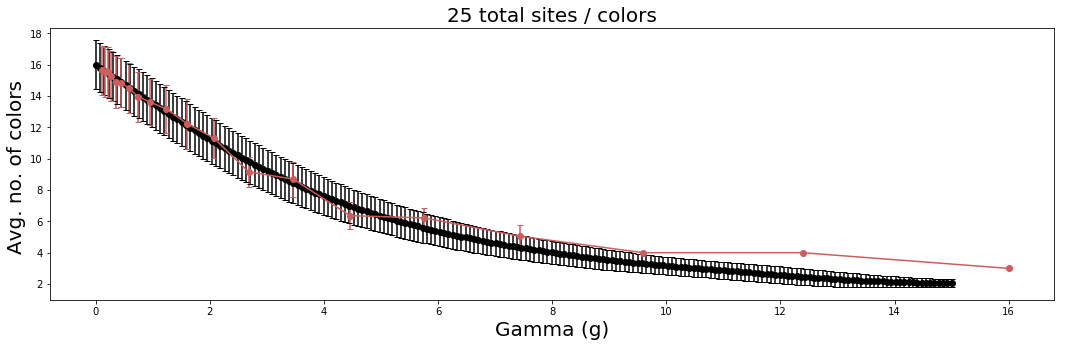

In [45]:
debugging = True
prt = False
ngamma = 20
gammas = np.logspace(-3,4, base=2, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (5, 25, gammas, J=0, alpha=0)